<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/Review_Toko_Baju_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [8]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [9]:
url2 = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df2 = pd.read_csv(url2)

# Tampilkan 5 baris pertama
print(df2[['Review Text', 'Recommended IND']].head())


                                         Review Text  Recommended IND
0  Absolutely wonderful - silky and sexy and comf...                1
1  Love this dress!  it's sooo pretty.  i happene...                1
2  I had such high hopes for this dress and reall...                0
3  I love, love, love this jumpsuit. it's fun, fl...                1
4  This shirt is very flattering to all due to th...                1


Bersihkan Data

In [10]:
# Hapus baris yang Review Text-nya kosong
df2 = df2.dropna(subset=['Review Text', 'Recommended IND'])

# Bersihkan teks review
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\S+", "", s)
    s = re.sub(r"[^a-z0-9\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df2['clean_review'] = df2['Review Text'].apply(clean_text)
df2['label'] = df2['Recommended IND'].astype(int)


Tokenisasi & Padding

In [11]:
num_words = 30000
maxlen = 500

tokenizer2 = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer2.fit_on_texts(df2['clean_review'])

X2_seq = tokenizer2.texts_to_sequences(df2['clean_review'])
X2 = pad_sequences(X2_seq, maxlen=maxlen, padding='post', truncating='post')
y2 = df2['label'].values


Split Training & Testing

In [12]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)


Buat Model BiRNN

In [15]:
embedding_dim = 128

model2 = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Latih Model

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    X2_train, y2_train,
    epochs=10,
    batch_size=64,
    validation_data=(X2_test, y2_test),
    callbacks=[early_stop]
)


Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9258 - loss: 0.1900 - val_accuracy: 0.8852 - val_loss: 0.2783
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9471 - loss: 0.1435 - val_accuracy: 0.8768 - val_loss: 0.2994
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9561 - loss: 0.1226 - val_accuracy: 0.8863 - val_loss: 0.3674
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9660 - loss: 0.0935 - val_accuracy: 0.8823 - val_loss: 0.4720


Visualisasi Akurasi dan Loss

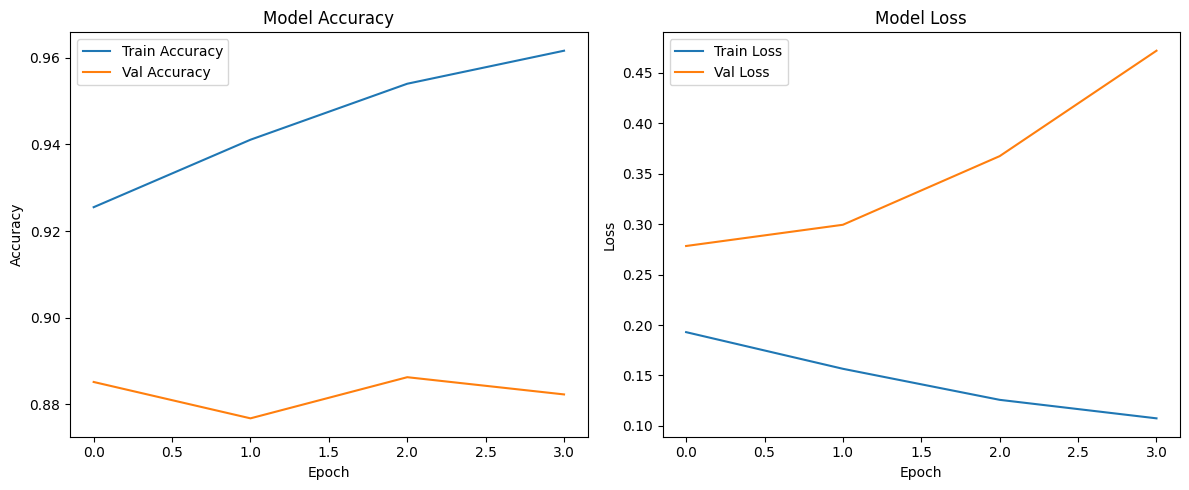

In [18]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluasi Model

In [19]:
# Prediksi dan konversi probabilitas ke 0/1
y2_pred_prob = model2.predict(X2_test)
y2_pred = (y2_pred_prob >= 0.5).astype(int).flatten()

# Hitung metrik evaluasi
acc2 = accuracy_score(y2_test, y2_pred)
prec2 = precision_score(y2_test, y2_pred)
rec2 = recall_score(y2_test, y2_pred)
f1_2 = f1_score(y2_test, y2_pred)
auc2 = roc_auc_score(y2_test, y2_pred_prob)

print(f"Accuracy: {acc2:.4f}")
print(f"Precision: {prec2:.4f}")
print(f"Recall: {rec2:.4f}")
print(f"F1 Score: {f1_2:.4f}")
print(f"AUC: {auc2:.4f}")


142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step
Accuracy: 0.8852
Precision: 0.9267
Recall: 0.9337
F1 Score: 0.9302
AUC: 0.9184


Plot ROC Curve

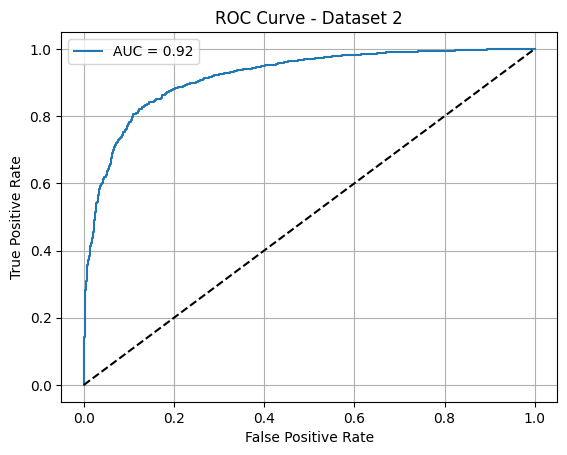

In [20]:
fpr2, tpr2, _ = roc_curve(y2_test, y2_pred_prob)

plt.figure()
plt.plot(fpr2, tpr2, label=f"AUC = {auc2:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Dataset 2")
plt.legend()
plt.grid()
plt.show()


Library

In [23]:
!pip install -q -U keras-tuner

import keras_tuner as kt
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


Buat Function Model untuk Tuning

In [24]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=maxlen
    ))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=False
    )))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


Inisialisasi Tuner dan Jalankan Tuning

In [25]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='birnn_review_toko_baju'
)

tuner.search_space_summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X2_train, y2_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=64
)


Trial 5 Complete [00h 26m 23s]
val_accuracy: 0.8973226547241211

Best val_accuracy So Far: 0.8987027406692505
Total elapsed time: 03h 22m 19s


Evaluasi Model Terbaik

In [ ]:
# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Lanjutkan training jika perlu
history_best = best_model.fit(
    X2_train, y2_train,
    validation_data=(X2_test, y2_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

# Evaluasi
y_pred_prob_best = best_model.predict(X2_test)
y_pred_best = (y_pred_prob_best >= 0.5).astype(int).flatten()

acc = accuracy_score(y2_test, y_pred_best)
prec = precision_score(y2_test, y_pred_best)
rec = recall_score(y2_test, y_pred_best)
f1 = f1_score(y2_test, y_pred_best)
auc = roc_auc_score(y2_test, y_pred_prob_best)

print(f"Best Accuracy: {acc:.4f}")
print(f"Best Precision: {prec:.4f}")
print(f"Best Recall: {rec:.4f}")
print(f"Best F1 Score: {f1:.4f}")
print(f"Best AUC: {auc:.4f}")


Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 760s 3s/step - accuracy: 0.9037 - loss: 0.2414 - val_accuracy: 0.8914 - val_loss: 0.2569
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 797s 3s/step - accuracy: 0.9101 - loss: 0.2170 - val_accuracy: 0.8885 - val_loss: 0.2524
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.9173 - loss: 0.1978 - val_accuracy: 0.8037 - val_loss: 0.4276
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - accuracy: 0.9212 - loss: 0.1919 - val_accuracy: 0.8918 - val_loss: 0.2637
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9328 - loss: 0.1821

In [27]:
# Ambil best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluasi ulang pada validation data
loss, best_accuracy = best_model.evaluate(X2_test, y2_test, verbose=0)

print("=== Best Configuration ===")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Embedding Dim: {best_hps.get('embedding_dim')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout 1: {best_hps.get('dropout_rate')}")
print(f"Dropout 2: {best_hps.get('dropout_rate2')}")
print(f"Optimizer: {best_hps.get('optimizer')}")


=== Best Configuration ===
Best Validation Accuracy: 0.8881
Embedding Dim: 256
Dense Units: 64
Dropout 1: 0.5
Dropout 2: 0.4
Optimizer: rmsprop
